In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap
import seaborn as sns
from datetime import datetime
from typing import List, Tuple, Dict
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy import stats


from validate_dowscaled_et import prepare_data_for_plotting
from utils.plot_config import set_plot_style
from time_series_metrics import calculate_metrics

from utils import date_utils, ee_utils, data_utils
from utils.ee_utils import back_to_float, back_to_int

import re

import warnings

warnings.filterwarnings("ignore")

In [3]:
ee.Initialize(project="thurgau-irrigation")

### Import validation data and WaPOR ET data

In [ ]:
years_to_process = range(2018, 2022)

asset_name = "projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_10m_dekadal_test_refactor"
ET_wapor_10m = ee_utils.merge_collections(years_to_process, asset_name)

# et_collection = ee.ImageCollection(
#     "projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_300m_TG_2018-2022"
# ).filterDate("2018-01-01", "2022-01-01")

dates_for_validation = date_utils.store_collection_dates(ET_wapor_10m)

In [ ]:
dates_for_validation

In [ ]:
ET_wapor_10m.first().propertyNames().getInfo()

In [ ]:
# # Fix image with missing date
# image_id = "2_WaPOR_ET_downscaled_2021-02_D2"
# image = et_collection.filter(ee.Filter.eq('system:index', image_id)).first()

# date_str = "2021-02-11"
# date = datetime.strptime(date_str, "%Y-%m-%d")

# image_with_date = image.set("system:time_start", date.timestamp() * 1000)
# image_with_date.date().getInfo()

## Rietholzbach

In [ ]:
rietholzbach_validation_et_collection = ee.FeatureCollection("projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021").sort("system:time_start")

In [ ]:
rietholzbach_validation_df = geemap.ee_to_df(rietholzbach_validation_et_collection)

In [ ]:
def resample_and_interpolate_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample a DataFrame with a date column, setting daily frequency and interpolating missing values.

    Args:
        df (DataFrame): The input DataFrame containing a date column named 'date_[YYYYmmdd]'.

    Returns:
        DataFrame: A DataFrame resampled to daily frequency with interpolated values.
    """
    df["date"] = pd.to_datetime(df["date_[YYYYmmdd]"])
    df = df.drop(columns=["date_[YYYYmmdd]"])
    df = df.set_index("date")
    df = df.resample("D").asfreq()
    df = df.interpolate(method="time")
    return df

In [ ]:
rietholzbach_validation_df = resample_and_interpolate_df(rietholzbach_validation_df)

In [ ]:
rietholzbach_validation_ET = data_utils.aggregate_time_series(rietholzbach_validation_df, dates_for_validation)
rietholzbach_validation_ET['date'] = pd.to_datetime(rietholzbach_validation_ET['date'])
rietholzbach_validation_ET["average_evapotranspiration_[mm/d]"] = rietholzbach_validation_ET["average_evapotranspiration_[mm/d]"].round(0)

In [ ]:
point = rietholzbach_validation_et_collection.first().geometry()
raster_collection = ee_utils.extract_pixel_values(et_collection, point, band="ET")
raster_collection_downscaled = ee_utils.extract_pixel_values(et_collection_downscaled, point, band="downscaled")

In [ ]:
Map = geemap.Map()

vis_params = {
    "bands": ["ET"],
    "min": 0,
    "max": 5,
    "palette": ["white", "blue", "green", "yellow", "red"],
}

image = ee.Image(et_collection.toList(et_collection.size()).get(20))

Map.addLayer(image, vis_params, "ET")
Map.addLayer(point, {"color": "red"}, "Point")
Map.setCenter(8.2275, 47.6966, 8)
Map

In [ ]:
waport_df = geemap.ee_to_df(ee.FeatureCollection(raster_collection))
waport_df["evapotranspiration[mm/d]"] = (waport_df["pixel_value"])
waport_df["date"] = pd.to_datetime(waport_df["date"])

waport_df_downscaled = geemap.ee_to_df(ee.FeatureCollection(raster_collection_downscaled))
waport_df_downscaled["evapotranspiration[mm/d]"] = (waport_df_downscaled["pixel_value"]/100).round(0)
waport_df_downscaled["date"] = pd.to_datetime(waport_df_downscaled["date"])

In [ ]:
waport_df

### Visually validate the WAPOR ET data

In [ ]:
set_plot_style()  

plt.figure(figsize=(12, 8))  # Increased height to accommodate bottom legend

# Plot the data
sns.lineplot(
    data=rietholzbach_validation_ET,
    x="date",
    y="average_evapotranspiration_[mm/d]",
    label="Validation ET Rietholzbach",
    color="#1f77b4",
)
sns.lineplot(
    data=waport_df,
    x="date",
    y="evapotranspiration[mm/d]",
    label="Original ET WaPOR",
    color="#ff7f0e",
)
sns.lineplot(
    data=waport_df_downscaled,
    x="date",
    y="evapotranspiration[mm/d]",
    label="Downscaled ET WaPOR",
    color="#2ca02c",
)

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/d]")

plt.ylim(bottom=0)

# Add green background for April to October
for year in range(
    rietholzbach_validation_ET["date"].dt.year.min(),
    rietholzbach_validation_ET["date"].dt.year.max() + 1,
):
    plt.axvspan(
        pd.Timestamp(f"{year}-04-01"),
        pd.Timestamp(f"{year}-10-31"),
        facecolor="green",
        alpha=0.1,
        zorder=0,
    )

# Create a custom patch for the legend
green_patch = mpatches.Patch(
    color="green", alpha=0.1, label="Cropping Season (Apr-Oct)"
)

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    borderaxespad=0.0,
)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig(
    "/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_validation_Rietholzbach_10d_aggregate_from_coarse.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### Quantitative validation

In [ ]:
metrics = calculate_metrics(rietholzbach_validation_ET['average_evapotranspiration_[mm/d]'], waport_df['evapotranspiration[mm/d]'])
metrics_downscaled = calculate_metrics(rietholzbach_validation_ET['average_evapotranspiration_[mm/d]'], waport_df_downscaled['evapotranspiration[mm/d]'])

metrics, metrics_downscaled

In [ ]:
metrics

## Comparing WaPOR ET with Rietholzbach ET and Landsat ET

### Getting the landsat image and preparing it for plotting

In [ ]:
def extract_landsat_evapotranspiration_data(
    point: ee.Geometry, time_period: Tuple[str, str]
) -> pd.DataFrame:
    """
    Extracts evapotranspiration data from the Landsat monthly collection for a given point and time period.

    Args:
        point (ee.Geometry): The geographic point for which to extract data.
        time_period (Tuple[str, str]): A tuple containing the start and end date (YYYY-MM-DD) for filtering the data.

    Returns:
        pd.DataFrame: A DataFrame containing the evapotranspiration data for the specified point and time period.
    """
    # Load the evapotranspiration image collection
    ET_landsat_cantons = ee.ImageCollection(
        "projects/thurgau-irrigation/assets/Thurgau/Landsat_ET_gap_filled_2018-2022"
    ).map(lambda img: back_to_float(img, 100))

    # Extract pixel values for the given point
    landsat_ET_fc = ee_utils.extract_pixel_values(
        ET_landsat_cantons, point, band="fitted_ET"
    )
    landsat_ET_df = geemap.ee_to_df(landsat_ET_fc)

    # Convert date column to datetime
    landsat_ET_df["date"] = pd.to_datetime(landsat_ET_df["date"])

    # Set all dates to the first day of their respective months
    landsat_ET_df["date"] = landsat_ET_df["date"].dt.to_period("M").dt.to_timestamp()

    # Rename pixel value column to evapotranspiration
    landsat_ET_df["evapotranspiration[mm/month]"] = landsat_ET_df["pixel_value"].apply(
        lambda x: 0 if x < 0 else x
    )

    # Filter DataFrame for the specified time period
    start_date, end_date = time_period
    landsat_ET_df = landsat_ET_df[
        (landsat_ET_df["date"] >= start_date) & (landsat_ET_df["date"] <= end_date)
    ]

    # Set NaN values to 0
    landsat_ET_df["evapotranspiration[mm/month]"] = landsat_ET_df[
        "evapotranspiration[mm/month]"
    ].fillna(0)

    return landsat_ET_df

In [ ]:
landsat_ET_df = extract_landsat_evapotranspiration_data(point, ("2018-01-01", "2021-12-31"))

In [ ]:
landsat_ET_df

### Resampling dekadal WaPOR data to monthly data. The resampling is done by multiplying the dekadal data by the number of days in each dekad and then summing the values for each month.

In [ ]:
# wapor_monthly_et = ee_utils.aggregate_to_monthly(et_collection)
# wapor_monthly_et_fc = ee_utils.extract_pixel_values(wapor_monthly_et, point)
# waport_monthly_df = geemap.ee_to_df(ee.FeatureCollection(wapor_monthly_et_fc))
# waport_monthly_df["evapotranspiration[mm/month]"] = waport_monthly_df["pixel_value"] / 100
# waport_monthly_df["date"] = pd.to_datetime(waport_monthly_df["date"])

In [ ]:
dates_for_validation = date_utils.store_collection_dates(wapor_monthly_et)

### Resample Rietholzbach validation data to monthly

In [ ]:
rietholzbach_monthly_ET_df = data_utils.aggregate_time_series(rietholzbach_validation_df, dates_for_validation, aggregation_type="sum")
rietholzbach_monthly_ET_df.rename(columns={"sum_evapotranspiration_[mm/d]": "sum_evapotranspiration_[mm/month]"}, inplace=True)

### Plotting the validation

In [ ]:
plt.figure(figsize=(12, 8))  

# Plot the data
sns.lineplot(
    data=rietholzbach_monthly_ET_df,
    x="date",
    y="sum_evapotranspiration_[mm/month]",
    label="Validation ET Rietholzbach",
    color="#1f77b4",
)
sns.lineplot(
    data=waport_monthly_df,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Downscaled ET WaPOR",
    color="#ff7f0e",
)
sns.lineplot(
    data=landsat_ET_df,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Landsat ET",
    color="#9467bd"
)

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/month]")

plt.ylim(bottom=0)

# Add green background for April to October
for year in range(
    rietholzbach_monthly_ET_df["date"].dt.year.min(),
    rietholzbach_monthly_ET_df["date"].dt.year.max() + 1,
):
    plt.axvspan(
        pd.Timestamp(f"{year}-04-01"),
        pd.Timestamp(f"{year}-10-31"),
        facecolor="green",
        alpha=0.1,
        zorder=0,
    )

# Create a custom patch for the legend
green_patch = mpatches.Patch(
    color="green", alpha=0.1, label="Cropping Season (Apr-Oct)"
)

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    borderaxespad=0.0,
)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig("/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_Landsat_validation_Rietholzbach_monthly.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
metrics = calculate_metrics(rietholzbach_monthly_ET_df['sum_evapotranspiration_[mm/month]'], waport_monthly_df['evapotranspiration[mm/month]'])
print(metrics)
metrics = calculate_metrics(rietholzbach_monthly_ET_df['sum_evapotranspiration_[mm/month]'], landsat_ET_df['evapotranspiration[mm/month]'])
print(metrics)

## Oensingen
### Get validation data

In [4]:
oesnsingen_validation_et_collection = ee.FeatureCollection("projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_oensingen_2004_2020").sort("system:time_start")
oesnsingen_validation_df = geemap.ee_to_df(oesnsingen_validation_et_collection)
oesnsingen_validation_df["date"] = pd.to_datetime(oesnsingen_validation_df["date_[YYYYmmdd]"])
oesnsingen_validation_df = oesnsingen_validation_df.drop(columns=["date_[YYYYmmdd]"])

oesnsingen_validation_df = oesnsingen_validation_df[
    (oesnsingen_validation_df["date"] >= "2018-01-01") & (oesnsingen_validation_df["date"] <= "2020-12-31")
]

oesnsingen_validation_df["evapotranspiration_[mm/month]"] = oesnsingen_validation_df["evapotranspiration_[mm/month]"].round(0).fillna(0)

In [5]:
oensingen_point = oesnsingen_validation_et_collection.first().geometry()

### Get WaPORT ET data for region around Oensingen

In [6]:
years_to_process = [2018, 2019, 2020]

asset_name = "projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_10m_dekadal_oensingen"
et_collection_oensingen = ee_utils.merge_collections(years_to_process, asset_name)


wapor_monthly_et = ee_utils.aggregate_to_monthly(et_collection_oensingen)
wapor_monthly_et_fc = ee_utils.extract_pixel_values(wapor_monthly_et, oensingen_point)
waport_monthly_df = geemap.ee_to_df(ee.FeatureCollection(wapor_monthly_et_fc))
waport_monthly_df["evapotranspiration[mm/month]"] = waport_monthly_df["pixel_value"] / 100
waport_monthly_df["date"] = pd.to_datetime(waport_monthly_df["date"])


# et_collection_original = ee.ImageCollection(
#     "projects/thurgau-irrigation/assets/ET_WaPOR_300m_Oensingen_2018-2022"
# ).filterDate("2018-01-01", "2021-01-01")


# wapor_monthly_et_original = ee_utils.aggregate_to_monthly(et_collection_original, bands=["ET"])
# wapor_monthly_et_fc_original = ee_utils.extract_pixel_values(wapor_monthly_et_original, oensingen_point, band="ET")
# waport_monthly_df_original = geemap.ee_to_df(ee.FeatureCollection(wapor_monthly_et_fc_original))
# waport_monthly_df_original["evapotranspiration[mm/month]"] = waport_monthly_df_original["pixel_value"]
# waport_monthly_df_original["date"] = pd.to_datetime(waport_monthly_df_original["date"])

### Get landsat data

In [7]:
# landsat_ET_df_oesnsingen = extract_landsat_evapotranspiration_data(oensingen_point, ("2018-01-01", "2020-12-31")) 

### Plotting

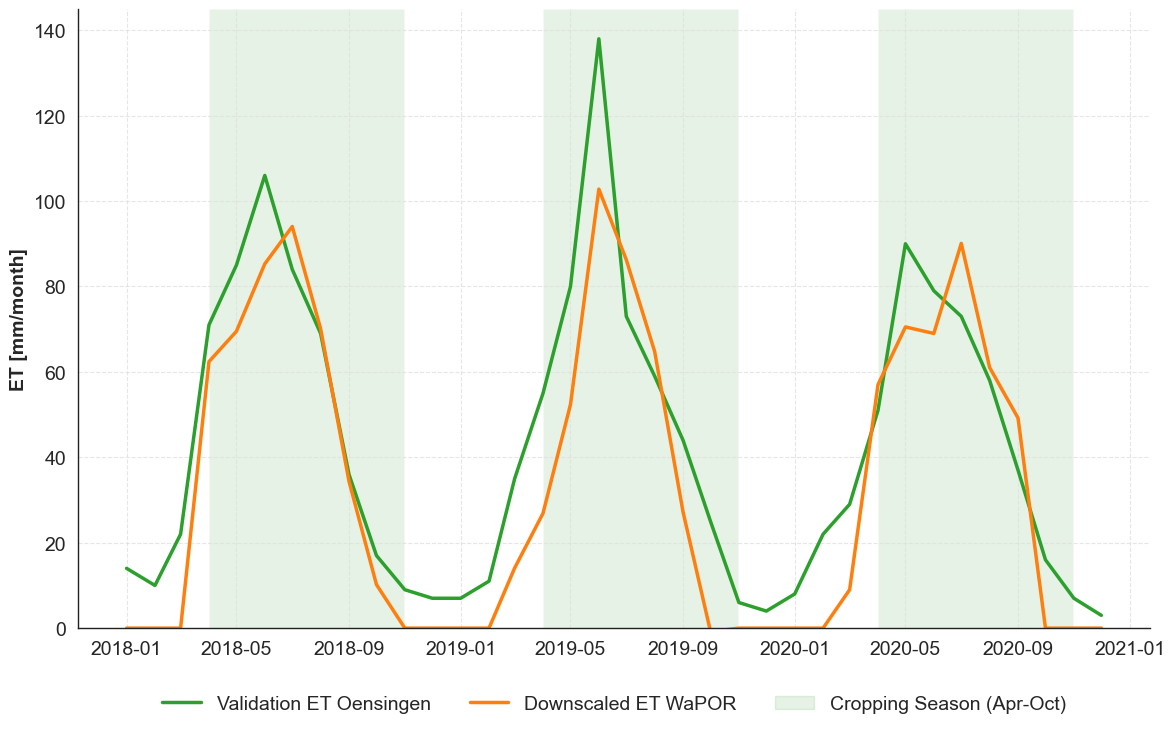

In [8]:
set_plot_style()

plt.figure(figsize=(12, 8))  

# Plot the data
sns.lineplot(
    data=oesnsingen_validation_df,
    x="date",
    y="evapotranspiration_[mm/month]",
    label="Validation ET Oensingen",
    color="#2ca02c",
)
sns.lineplot(
    data=waport_monthly_df,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Downscaled ET WaPOR",
    color="#ff7f0e",
)

# sns.lineplot(
#     data=waport_monthly_df_original,
#     x="date",
#     y="evapotranspiration[mm/month]",
#     label="Original ET WaPOR",
#     color="blue",
# )

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/month]")

plt.ylim(bottom=0)

# Add green background for April to October
for year in range(
    oesnsingen_validation_df["date"].dt.year.min(),
    oesnsingen_validation_df["date"].dt.year.max() + 1,
):
    plt.axvspan(
        pd.Timestamp(f"{year}-04-01"),
        pd.Timestamp(f"{year}-10-31"),
        facecolor="green",
        alpha=0.1,
        zorder=0,
    )

# Create a custom patch for the legend
green_patch = mpatches.Patch(
    color="green", alpha=0.1, label="Cropping Season (Apr-Oct)"
)

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    borderaxespad=0.0,
)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig("/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_Landsat_validation_Oensingen_monthly.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
# File: src/validation/et_validation_metrics.py

from typing import Tuple, Dict
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error


def prepare_validation_data(
    df_observed: pd.DataFrame,
    df_predicted: pd.DataFrame,
    observed_col: str,
    predicted_col: str,
    growing_season_only: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare and align validation data for comparison.

    Args:
        df_observed: DataFrame containing observed values
        df_predicted: DataFrame containing predicted values
        observed_col: Name of column containing observed values
        predicted_col: Name of column containing predicted values
        growing_season_only: If True, only consider data from April to October

    Returns:
        Tuple of aligned observed and predicted values as numpy arrays
    """
    # Merge dataframes on date
    merged_df = pd.merge(
        df_observed[["date", observed_col]],
        df_predicted[["date", predicted_col]],
        on="date",
        how="inner",
    )

    if growing_season_only:
        # Filter for growing season (April to October)
        merged_df = merged_df[merged_df["date"].dt.month.between(4, 10)]

    return (merged_df[observed_col].values, merged_df[predicted_col].values)


def calculate_validation_metrics(
    observed: np.ndarray, predicted: np.ndarray
) -> Dict[str, float]:
    """
    Calculate various validation metrics for comparing observed and predicted values.

    Args:
        observed: Array of observed values
        predicted: Array of predicted values

    Returns:
        Dictionary containing various validation metrics
    """
    # Remove any pairs where either value is NaN
    mask = ~(np.isnan(observed) | np.isnan(predicted))
    observed = observed[mask]
    predicted = predicted[mask]

    # Calculate basic statistics
    mean_obs = np.mean(observed)
    mean_pred = np.mean(predicted)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    mae = mean_absolute_error(observed, predicted)

    # Calculate relative RMSE and MAE
    rrmse = (rmse / mean_obs) * 100  # as percentage
    rmae = (mae / mean_obs) * 100  # as percentage

    # Calculate R-squared
    r_squared = stats.pearsonr(observed, predicted)[0] ** 2

    # Calculate Nash-Sutcliffe efficiency
    nse = 1 - (
        np.sum((observed - predicted) ** 2)
        / np.sum((observed - np.mean(observed)) ** 2)
    )

    # Calculate bias metrics
    bias = np.mean(predicted - observed)
    relative_bias = (bias / mean_obs) * 100  # as percentage

    # Calculate Kling-Gupta Efficiency
    std_obs = np.std(observed)
    std_pred = np.std(predicted)

    r = stats.pearsonr(observed, predicted)[0]
    alpha = std_pred / std_obs
    beta = mean_pred / mean_obs

    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return {
        "R2": r_squared,
        "RMSE": rmse,
        "MAE": mae,
        "Relative_RMSE": rrmse,
        "Relative_MAE": rmae,
        "NSE": nse,
        "KGE": kge,
        "Bias": bias,
        "Relative_Bias": relative_bias,
        "Mean_Observed": mean_obs,
        "Mean_Predicted": mean_pred,
    }


def print_validation_summary(metrics: Dict[str, float]) -> None:
    """
    Print a formatted summary of validation metrics.

    Args:
        metrics: Dictionary of validation metrics
    """
    print("\nValidation Metrics Summary:")
    print("===========================")
    print(f"R² Score: {metrics['R2']:.3f}")
    print(f"RMSE: {metrics['RMSE']:.2f} mm/month")
    print(f"Relative RMSE: {metrics['Relative_RMSE']:.1f}%")
    print(f"MAE: {metrics['MAE']:.2f} mm/month")
    print(f"Relative MAE: {metrics['Relative_MAE']:.1f}%")
    print(f"Nash-Sutcliffe Efficiency: {metrics['NSE']:.3f}")
    print(f"Kling-Gupta Efficiency: {metrics['KGE']:.3f}")
    print(f"Bias: {metrics['Bias']:.2f} mm/month")
    print(f"Relative Bias: {metrics['Relative_Bias']:.1f}%")
    print(f"\nMean Values:")
    print(f"Observed: {metrics['Mean_Observed']:.2f} mm/month")
    print(f"Predicted: {metrics['Mean_Predicted']:.2f} mm/month")

In [10]:
# Prepare the data
observed = oesnsingen_validation_df["evapotranspiration_[mm/month]"]
predicted = waport_monthly_df["evapotranspiration[mm/month]"]

# Calculate metrics for all months
obs_data, pred_data = prepare_validation_data(
    oesnsingen_validation_df,
    waport_monthly_df,
    "evapotranspiration_[mm/month]",
    "evapotranspiration[mm/month]",
    growing_season_only=False
)

metrics_all = calculate_validation_metrics(obs_data, pred_data)
print("\nMetrics for all months:")
print_validation_summary(metrics_all)

# Calculate metrics for growing season only
obs_data_gs, pred_data_gs = prepare_validation_data(
    oesnsingen_validation_df,
    waport_monthly_df,
    "evapotranspiration_[mm/month]",
    "evapotranspiration[mm/month]",
    growing_season_only=True
)

metrics_gs = calculate_validation_metrics(obs_data_gs, pred_data_gs)
print("\nMetrics for growing season only (April-October):")
print_validation_summary(metrics_gs)


Metrics for all months:

Validation Metrics Summary:
R² Score: 0.877
RMSE: 15.49 mm/month
Relative RMSE: 36.2%
MAE: 13.10 mm/month
Relative MAE: 30.6%
Nash-Sutcliffe Efficiency: 0.794
Kling-Gupta Efficiency: 0.771
Bias: -9.30 mm/month
Relative Bias: -21.7%

Mean Values:
Observed: 42.78 mm/month
Predicted: 33.48 mm/month

Metrics for growing season only (April-October):

Validation Metrics Summary:
R² Score: 0.751
RMSE: 16.99 mm/month
Relative RMSE: 26.5%
MAE: 14.32 mm/month
Relative MAE: 22.3%
Nash-Sutcliffe Efficiency: 0.658
Kling-Gupta Efficiency: 0.819
Bias: -7.80 mm/month
Relative Bias: -12.2%

Mean Values:
Observed: 64.10 mm/month
Predicted: 56.30 mm/month
